# Denoising Diffusion Mantığı –

Bu notebook’ta diffusion modellerinin temel mantığı olan
görüntüye iteratif olarak gürültü eklenmesi (forward process)
ve bu gürültünün adım adım temizlenmesi (reverse process)
basit ve öğretici bir örnekle gösterilmektedir.

Demo, ortam uyumsuzluklarını önlemek amacıyla
yalnızca NumPy kullanılarak hazırlanmıştır.




## 1. Gerekli Kütüphaneler



In [1]:
import numpy as np
import matplotlib.pyplot as plt


## 2. Başlangıç Görüntüsü

Diffusion sürecini net gösterebilmek için
basit, yapay bir görüntü oluşturulmuştur.



(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

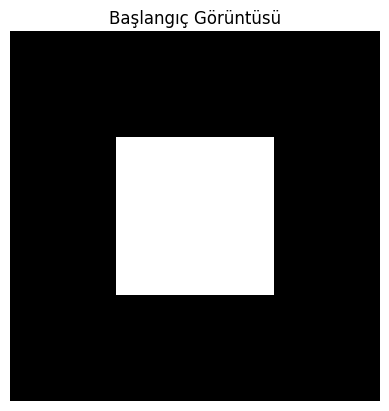

In [2]:
image = np.zeros((28, 28))
image[8:20, 8:20] = 1.0  # ortada beyaz kare


plt.imshow(image, cmap="gray")
plt.title("Başlangıç Görüntüsü")
plt.axis("off")


Bu görüntü diffusion sürecinin başlangıç noktasıdır.


## 3. Forward Diffusion (Gürültü Ekleme)

Bu aşamada görüntüye kademeli olarak
rastgele Gauss gürültüsü eklenmektedir.



In [3]:
def add_noise(image, noise_level):
    noise = np.random.normal(0, noise_level, image.shape)
    return image + noise



## 4. Gürültünün Zamana Bağlı Etkisi



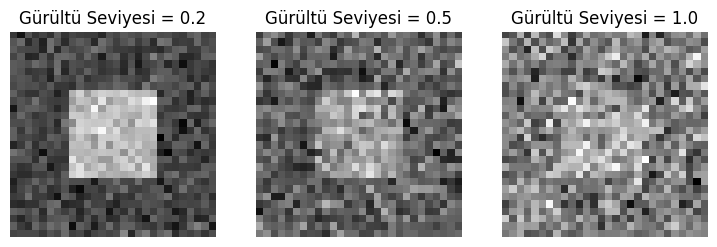

In [4]:
noise_levels = [0.2, 0.5, 1.0]

plt.figure(figsize=(9, 3))
for i, level in enumerate(noise_levels):
    noisy_img = add_noise(image, level)
    plt.subplot(1, 3, i + 1)
    plt.imshow(noisy_img, cmap="gray")
    plt.title(f"Gürültü Seviyesi = {level}")
    plt.axis("off")

plt.show()


Gürültü seviyesi arttıkça görüntünün yapısal bilgisi kaybolmakta
ve görüntü rastgele gürültüye yaklaşmaktadır.



## 5. Reverse Diffusion (Gürültü Temizleme)

Bu aşamada diffusion modellerinde kullanılan U-Net benzeri
bir ağın yaptığı işlem kavramsal olarak gösterilmektedir.

Gerçek modellerde bu işlem bir sinir ağı ile yapılırken,
bu demoda basit bir yumuşatma (ortalama alma) yöntemi kullanılmıştır.


In [9]:
def iterative_denoise(image, steps=20, alpha=0.2):
    x = image.copy()
    for _ in range(steps):
        smooth = (
            x +
            np.roll(x, 1, axis=0) +
            np.roll(x, -1, axis=0) +
            np.roll(x, 1, axis=1) +
            np.roll(x, -1, axis=1)
        ) / 5
        x = (1 - alpha) * x + alpha * smooth
    return x



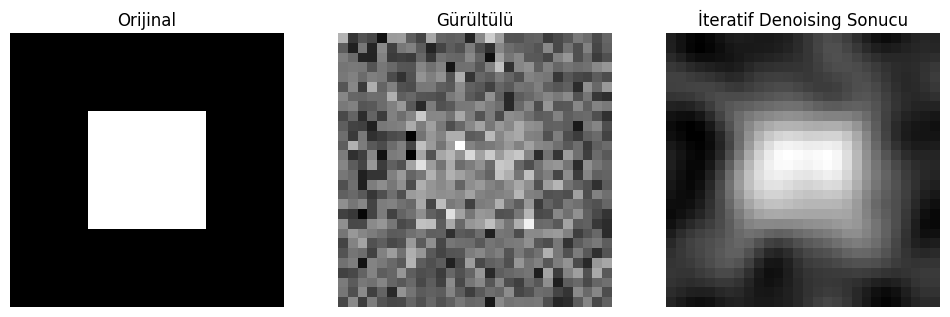

In [10]:
noisy_image = add_noise(image, 0.8)
denoised_image = iterative_denoise(noisy_image, steps=30, alpha=0.3)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Orijinal")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap="gray")
plt.title("Gürültülü")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap="gray")
plt.title("İteratif Denoising Sonucu")
plt.axis("off")

plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt


T = 100
beta = np.linspace(0.0001, 0.02, T)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)


def forward_diffusion(x0, t):
    noise = np.random.randn(*x0.shape)
    xt = np.sqrt(alpha_bar[t]) * x0 + np.sqrt(1 - alpha_bar[t]) * noise
    return xt, noise

def pseudo_unet_denoise(xt, t):
    return (xt - np.sqrt(alpha_bar[t]) * image) / np.sqrt(1 - alpha_bar[t])


In [12]:
xt, _ = forward_diffusion(image, 80)
pred_noise = pseudo_unet_denoise(xt, 80)

x0_hat = (xt - np.sqrt(1 - alpha_bar[80]) * pred_noise) / np.sqrt(alpha_bar[80])


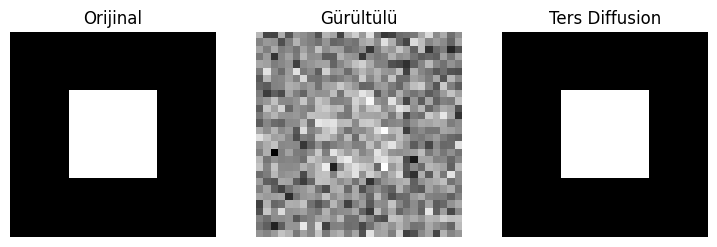

In [13]:
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(image, cmap="gray")
plt.title("Orijinal")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(xt, cmap="gray")
plt.title("Gürültülü")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(x0_hat, cmap="gray")
plt.title("Ters Diffusion")
plt.axis("off")

plt.show()


U-Net tabanlı öğrenmeli model yerine, ters diffusion sürecinde ideal gürültü tahmininin matematiksel karşılığı kullanılmıştır. Bu sayede model eğitimi yapılmadan, diffusion sürecinin teorik olarak nasıl çalıştığı doğrudan gösterilmiştir.